Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yiyu Gan"
COLLABORATORS = ""

---

# Problem description

To a large degree, financial data has traditionally been numeric in format.

But in recent years, non-numeric formats like image, text and audio have been introduced.  

Private companies have satellites orbiting the Earth taking photos and offering them to customers.  A financial analyst might be able to extract information from these photos that could aid in the prediction of the future price of a stock

- Approximate number of customers visiting each store: count number of cars in parking lot
- Approximate activity in a factory by counting number of supplier trucks arriving and number of delivery trucks leaving
- Approximate demand for a commodity at each location: count cargo ships traveling between ports

In this assignment, we will attempt to recognize ships in satellite photos.
This would be a first step toward
counting.

As in any other domain: specific knowledge of the problem area will make you a better analyst.

For this assignment, we will ignore domain-specific information and just try to use a labeled training set (photo plus a binary indicator for whether a ship is present/absent in the photo), assuming that the labels are perfect.



## Goal: 

In this notebook, you will need to create a model in `TensorFlow/Keras` to classify satellite photos.
- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    

You will create several Keras `Sequential` models, of increasing complexity
- A model that implements only a Classification Head (no transformations other than perhaps rearranging the image)
- A model that adds a Dense layer before the head
- (Later assignment) A model that adds Convolutional layers before the Head

## Learning objectives
- Learn how to construct Neural Networks using Keras Sequential model
- Appreciate how layer choices impact number of weights

# Imports modules

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.4.1
Version 2, minor 4


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [3]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [4]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [5]:
# Shuffle the data first
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek



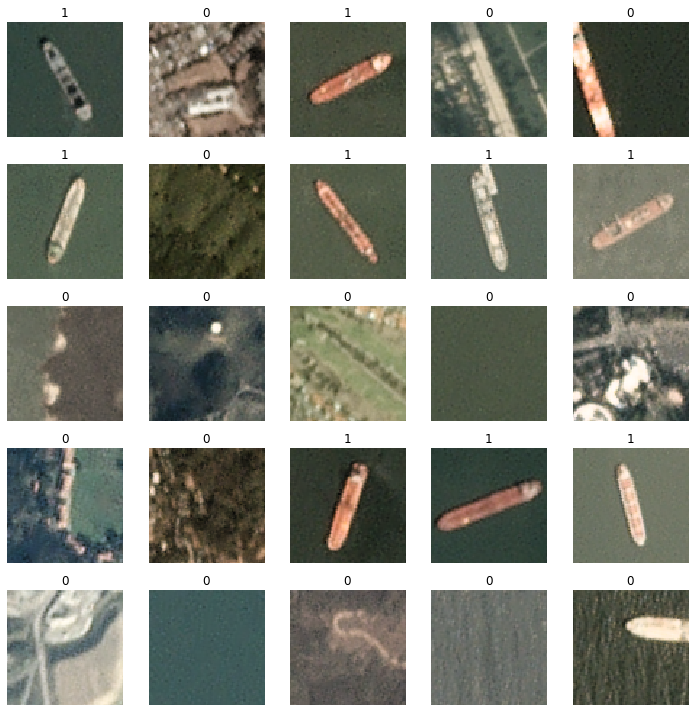

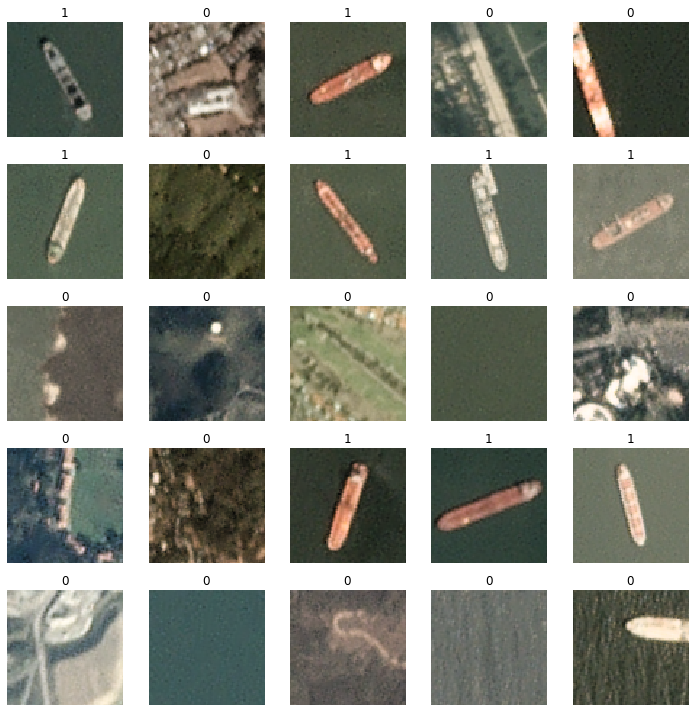

In [6]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

## Eliminate the color dimension

As a simplification, we will convert the image from color (RGB, with 3 "color" dimensions referred to as Red, Green and Blue) to gray scale.


In [7]:
print("Original shape of data: ", data.shape)

w = (.299, .587, .114)
data_bw = np.sum(data *w, axis=3)

print("New shape of data: ", data_bw.shape)

data_orig = data.copy()

Original shape of data:  (4000, 80, 80, 3)
New shape of data:  (4000, 80, 80)


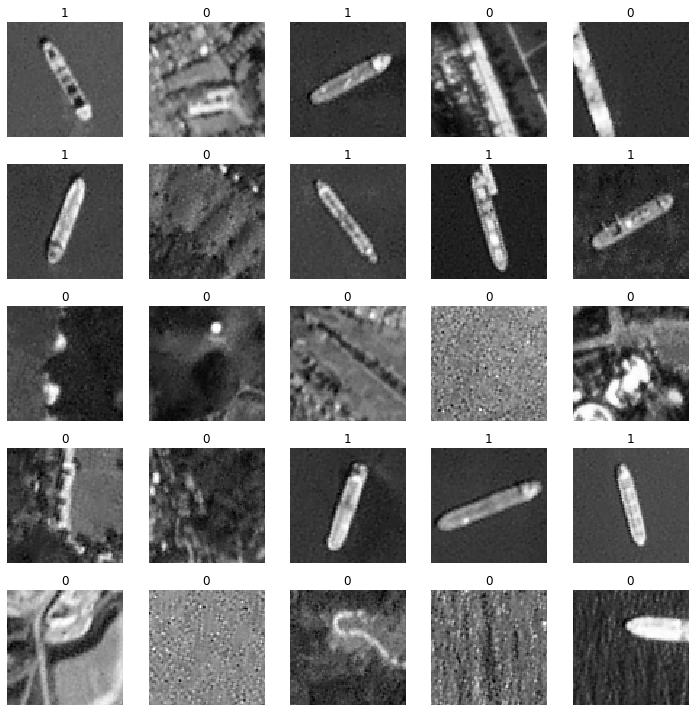

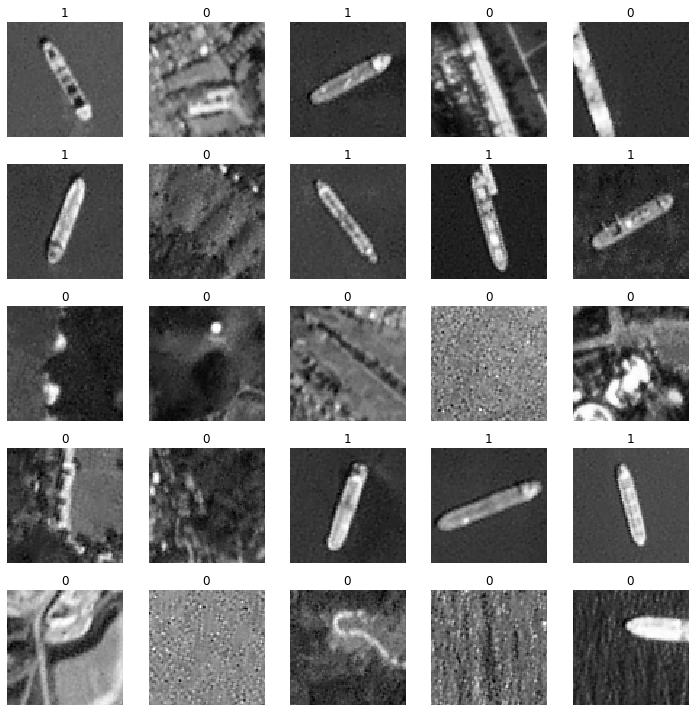

In [8]:
# Visualize the data samples
helper.showData(data_bw[:25], labels[:25], cmap="gray")

## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.



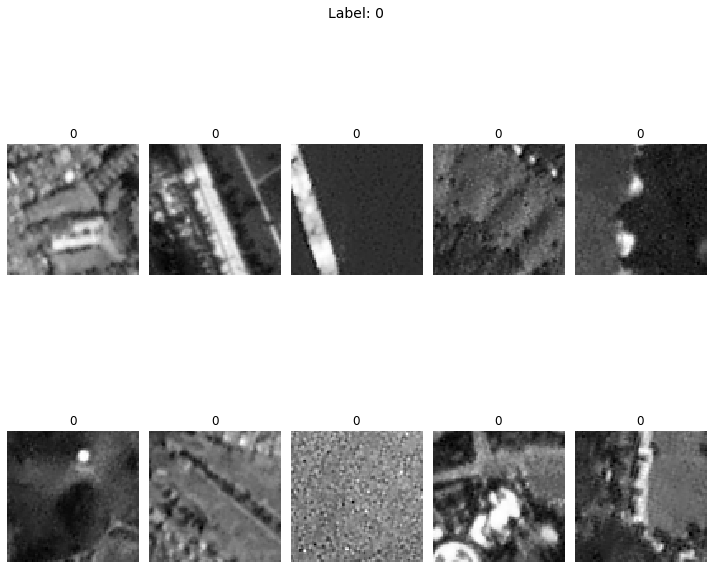

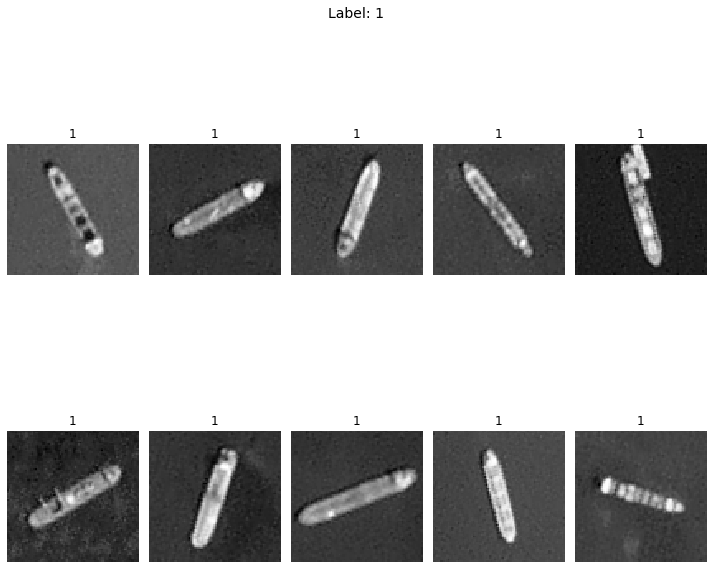

In [9]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data_bw[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values


In [10]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data_bw/255
y = labels

In [11]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80)
assert y.shape == (4000,)


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [12]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a model using only Classification, no data transformation (other than reshaping)

**Question:** You need to build a 1-layer (head layer only) network model with `tensorflow.keras`. Please name the head layer "dense_head".  

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. Since the dataset is 2-dimensional, you may want to use `Flatten()` in `tensorflow.keras.layers` to make your input data 1 dimensional. 
    - The `input shape` argument of the `Flatten()` layer should be the shape of a single example
2. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

3. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 


In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dropout
# Get the number of unique labels
num_cases = np.unique(labels).shape[0]
if num_cases > 2:
    activation = "softmax"
    loss = 'categorical_crossentropy'
else:
    activation = "sigmoid"
    num_cases = 1
    loss = 'binary_crossentropy'
    
# Set model0 equal to a Keras Sequential model
model0 = None

# YOUR CODE HERE
model0 = Sequential([Flatten(input_shape=(80, 80)),
                     Dropout(0.2),
                     layers.Dense(1, activation=activation, name='dense_head')
                    ])

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 6401      
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


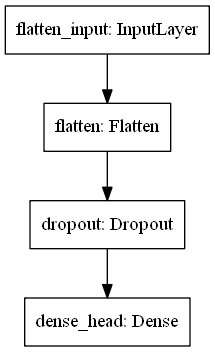

In [14]:
# We can plot our model here using plot_model()
plot_model(model0)

## Train model

**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history0`
- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/15
90/90 [==============================] - 1s 9ms/step - loss: 0.7066 - acc: 0.7315 - val_loss: 0.3901 - val_acc: 0.8333
Epoch 2/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4530 - acc: 0.8177 - val_loss: 0.4880 - val_acc: 0.8208
Epoch 3/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4384 - acc: 0.8259 - val_loss: 0.3854 - val_acc: 0.8542
Epoch 4/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4407 - acc: 0.8195 - val_loss: 0.3760 - val_acc: 0.8417
Epoch 5/15
90/90 [==============================] - 0s 4ms/step - loss: 0.3865 - acc: 0.8426 - val_loss: 0.3239 - val_acc: 0.8528
Epoch 6/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4167 - acc: 0.8308 - val_loss: 0.5407 - val_acc: 0.8181
Epoch 7/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4357 - acc: 0.8376 - val_loss: 0.3357 - val_acc: 0.8639
Epoch 8/15
90/90 [==============================] - 0s 4ms/step - loss: 0.4011 - acc: 0.84

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224A64A2148>,
       dtype=object))

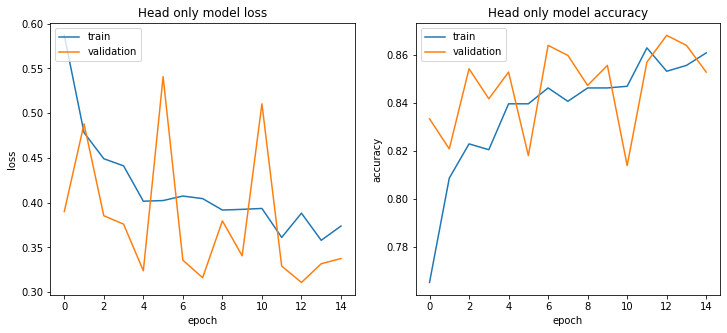

In [15]:
model_name0 = "Head only"

# YOUR CODE HERE
n_epochs = 15
metrics = ["acc"]
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model0.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history0 = model0.fit(X_train1, y_train1,
                     epochs=n_epochs,
                     validation_data=(X_val, y_val)
                     )
helper.plotTrain(history0, model_name=model_name0)

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.


In [16]:
# Set num_parameters0 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
num_parameters0 = model0.count_params()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  6401


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [17]:
score0 = []

# YOUR CODE HERE
score0 = model0.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

13/13 [==============================] - 0s 1ms/step - loss: 0.3225 - acc: 0.8850
Head only: Test loss: 0.32 / Test accuracy: 0.88


## Save the trained model0 and history0 for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [18]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory .\models\Head only already exists, files will be over-written.
Model saved in directory .\models\Head only; create an archive of this directory and submit with your assignment.
Directory .\models\Head only already exists, files will be over-written.


**Question:**

Make sure that the saved model can be successfully restored.
- Set variable `model_loss` to the value of the loss parameter you used in the `compile` statement for your model
- Set variable `model_metrics` to the value of the metrics parameter you used in the `compile` statement for  your model

In [19]:
## Restore the model (make sure that it works)

model_loss=None
model_metrics=None

# YOUR CODE HERE
model_loss = 'binary_crossentropy'
model_metrics = ['accuracy']

model_loaded = helper.loadModel(model_name0, loss=model_loss, metrics=model_metrics)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a new model with an additional Dense layer 

**Question:** 

We will add more layers to the original model0. 

- You need to add **AT LEAST ONE** Dense layer followed by an activation function (for example, ReLU)
    - You can add more layers if you like
    
- The number of units in your very **FIRST** Dense layer should be equal to the value of variable `num_features_1`, as set below.
    - Please name this Dense layer "dense_1" and the head layer "dense_head". 

**Hints:**
- Don't forget to flatten your input data!
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 

Hopefully your new model performs **better** than your first.

In [20]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_features_1 = 32

# YOUR CODE HERE
model1 = Sequential([Flatten(input_shape=(80, 80)),
                     layers.Dense(num_features_1, activation='relu', name='dense_1'),
                     Dropout(0.2),                     
                     layers.Dense(1, activation='sigmoid', name='head_dense')
                    ])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                204832    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
head_dense (Dense)           (None, 1)                 33        
Total params: 204,865
Trainable params: 204,865
Non-trainable params: 0
_________________________________________________________________


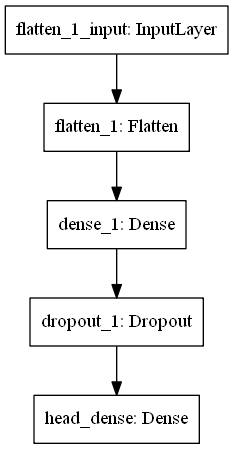

In [21]:
# Plot your model
plot_model(model1)

## Train your new model

**Question:**

Now that you have built your new model1,  you will compile and train model1. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: `categorical_crossentropy`; Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history1`
- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/15
58/58 [==============================] - 1s 8ms/step - loss: 0.8692 - acc: 0.6992 - val_loss: 0.4651 - val_acc: 0.8167
Epoch 2/15
58/58 [==============================] - 0s 5ms/step - loss: 0.5555 - acc: 0.7399 - val_loss: 0.5832 - val_acc: 0.7736
Epoch 3/15
58/58 [==============================] - 0s 5ms/step - loss: 0.4487 - acc: 0.8126 - val_loss: 0.3968 - val_acc: 0.8264
Epoch 4/15
58/58 [==============================] - 0s 5ms/step - loss: 0.4258 - acc: 0.8164 - val_loss: 0.3692 - val_acc: 0.8333
Epoch 5/15
58/58 [==============================] - 0s 5ms/step - loss: 0.4012 - acc: 0.8321 - val_loss: 0.3466 - val_acc: 0.8431
Epoch 6/15
58/58 [==============================] - 0s 5ms/step - loss: 0.3781 - acc: 0.8418 - val_loss: 0.3582 - val_acc: 0.8444
Epoch 7/15
58/58 [==============================] - 0s 5ms/step - loss: 0.3734 - acc: 0.8355 - val_loss: 0.4064 - val_acc: 0.8306
Epoch 8/15
58/58 [==============================] - 0s 5ms/step - loss: 0.3903 - acc: 0.84

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF2D2748>,
       dtype=object))

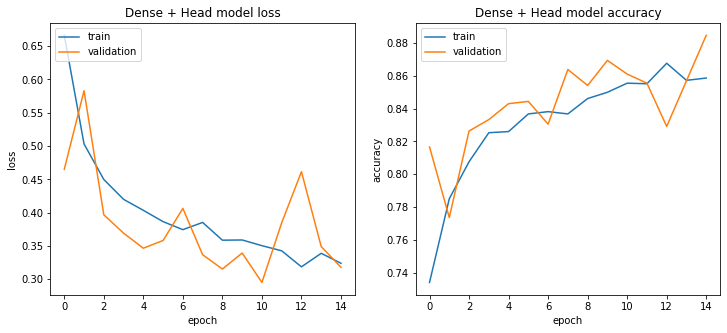

In [22]:
# Train the model using the API
model_name1 = "Dense + Head"

# YOUR CODE HERE
n_epochs = 15
metrics = ["acc"]
batch_size = 50
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history1 = model1.fit(X_train1, y_train1,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_val, y_val)
                     )
helper.plotTrain(history1, model_name=model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.

In [23]:
# Set num_parameters1 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
num_parameters1 = model1.count_params()

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 204865


## Evaluate the model

**Question:**

Evaluate the new model using the test dataset. Please store the model score in a variable named `score1`.   

In [24]:
score1 = []

# YOUR CODE HERE
score1 = model1.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

13/13 [==============================] - 0s 1ms/step - loss: 0.3193 - acc: 0.8850
Dense + Head: Test loss: 0.32 / Test accuracy: 0.88


Your new test score should be at least 0.8

# Save your trained model1 and history1

In [25]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory .\models\Dense + Head already exists, files will be over-written.
Model saved in directory .\models\Dense + Head; create an archive of this directory and submit with your assignment.
Directory .\models\Dense + Head already exists, files will be over-written.


## Your own model (Optional)
Now you can build your own model using what you have learned from the course. Some ideas to try:
- Try more than one additional `Dense` layer 
- Change the number of units (features) of your `Dense` layers. 
- Add `Dropout` layers; vary the parameter 
- Change the activation function
- Change the classifier
- ...

Observe the effect of each change on the Loss and Accuracy.

- You may want to use early stopping in training
    - In order to stop training when model metrics *worsen* rather than *improve*


For my own model, we will try **3 dense layers** above 1 head layer. 

Also, we will change the number of units from 32 to (32, 64, 128), which are numbers that we randomly choose. We will check if the perfromance imporves with more layers.

In [26]:
(n_hidden_1, n_hidden_2, n_hidden_3) = (32, 64, 128)
model2 = Sequential([Flatten(input_shape=(80, 80)),
                     layers.Dense(n_hidden_1, activation='relu', name='dense_1'),
                     layers.Dense(n_hidden_2, activation='relu', name='dense_2'),
                     layers.Dense(n_hidden_3, activation='relu', name='dense_3'),
                     Dropout(0.2),
                     layers.Dense(1, activation='sigmoid', name='dense_head')
                    ])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                204832    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 129       
Total params: 215,393
Trainable params: 215,393
Non-trainable params: 0
________________________________________________

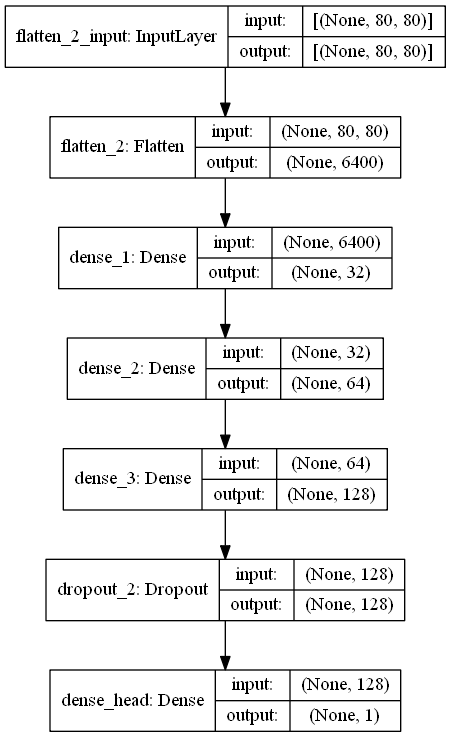

In [27]:
# Plot model
plot_model(model2, show_shapes=True)

## Train model

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.6735 - acc: 0.6606 - val_loss: 0.4783 - val_acc: 0.7583
Epoch 2/20
58/58 [==============================] - 0s 5ms/step - loss: 0.5025 - acc: 0.7802 - val_loss: 0.3886 - val_acc: 0.8208
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4519 - acc: 0.8129 - val_loss: 0.3726 - val_acc: 0.8375
Epoch 4/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4132 - acc: 0.8262 - val_loss: 0.3444 - val_acc: 0.8431
Epoch 5/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3791 - acc: 0.8475 - val_loss: 0.3387 - val_acc: 0.8500
Epoch 6/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3644 - acc: 0.8369 - val_loss: 0.4598 - val_acc: 0.8375
Epoch 7/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3608 - acc: 0.8502 - val_loss: 0.3104 - val_acc: 0.8542
Epoch 8/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3686 - acc: 0.85

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224A88BC208>,
       dtype=object))

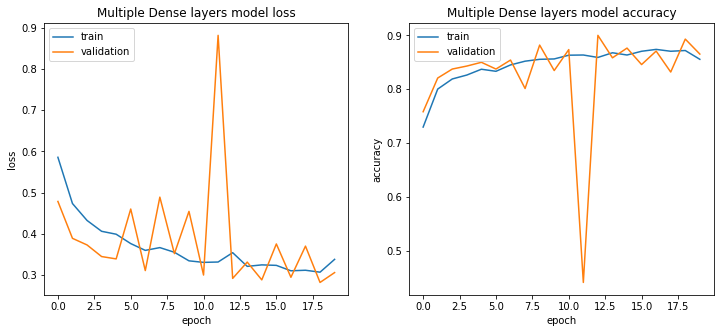

In [28]:
# Train the model using the API
model_name2 = "Multiple Dense layers"

n_epochs = 20
metrics = ["acc"]
batch_size = 50
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history2 = model2.fit(X_train1, y_train1,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_val, y_val),
                      shuffle=True
                     )
helper.plotTrain(history2, model_name=model_name2)

In [29]:
num_parameters2 = model2.count_params()

print('Parameters number in model2:', num_parameters2)

Parameters number in model2: 215393


In [30]:
score2 = []

score2 = model2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

13/13 [==============================] - 0s 1ms/step - loss: 0.3310 - acc: 0.8625
Multiple Dense layers: Test loss: 0.33 / Test accuracy: 0.86


Above 2 figures show that our model might have some **overfitting problems** while performing in the validation set. And the accuracy is decreased compared to model1, which only uses on dense layer. So, we will try to solve this problem in the following sections. Since this, we will decrease the units each layer a little bit.

In [31]:
(n_hidden_1, n_hidden_2, n_hidden_3) = (30, 60, 100)
model2 = Sequential([Flatten(input_shape=(80, 80)),
                     layers.Dense(n_hidden_1, activation='relu', name='dense_1'),
                     layers.Dense(n_hidden_2, activation='relu', name='dense_2'),
                     layers.Dense(n_hidden_3, activation='relu', name='dense_3'),
                     Dropout(0.2),
                     layers.Dense(1, activation='sigmoid', name='dense_head')
                    ])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                192030    
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 101       
Total params: 200,091
Trainable params: 200,091
Non-trainable params: 0
________________________________________________

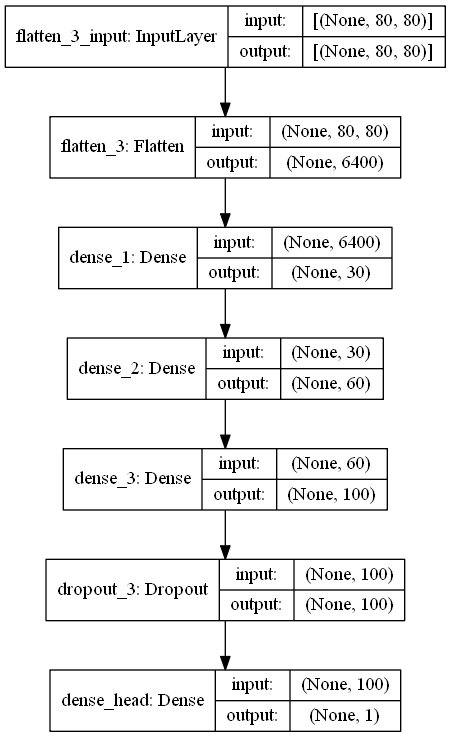

In [32]:
# Plot model
plot_model(model2, show_shapes=True)

Epoch 1/20
58/58 [==============================] - 1s 9ms/step - loss: 0.6697 - acc: 0.6764 - val_loss: 0.4889 - val_acc: 0.7653
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.5151 - acc: 0.7743 - val_loss: 0.7785 - val_acc: 0.5236
Epoch 3/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4792 - acc: 0.7893 - val_loss: 0.4193 - val_acc: 0.8181
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3942 - acc: 0.8335 - val_loss: 0.3744 - val_acc: 0.8417
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4011 - acc: 0.8320 - val_loss: 0.3729 - val_acc: 0.8417
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3692 - acc: 0.8452 - val_loss: 0.3393 - val_acc: 0.8417
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3648 - acc: 0.8432 - val_loss: 0.3279 - val_acc: 0.8444
Epoch 8/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3576 - acc: 0.84

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224A80CE588>,
       dtype=object))

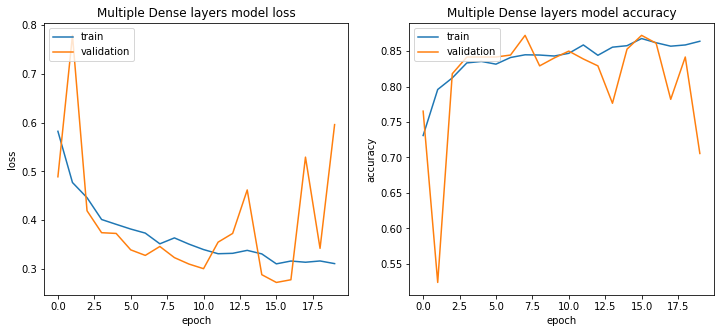

In [33]:
# Train the model using the API
n_epochs = 20
metrics = ["acc"]
batch_size = 50
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history2 = model2.fit(X_train1, y_train1,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_val, y_val),
                      shuffle=True
                     )
helper.plotTrain(history2, model_name=model_name2)

**The figures with modle using units (30, 60, 100) looks better fitting than the model using units (32, 64, 128).** Especially the figure of model accuracy, smaller number of units each layer performs better.

## Evaluate the model

In [34]:
score2 = []

score2 = model2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

13/13 [==============================] - 0s 2ms/step - loss: 0.6333 - acc: 0.7200
Multiple Dense layers: Test loss: 0.63 / Test accuracy: 0.72


The overall accurancy is improved compared to model1, the test loss is decreased as well, which implys decrease the number of units does improve the perfromance of our model.

However, when we review the process of epochs and the figures of model loss and accuracy, we could find the accuracy rates between 20 epochs are pretty volatile, ranging from around 0.75 to 0.9. So, we could try to use **Early Stopping** to check if we can improve our model2 performance.

## Early Stopping
Then we will try to use early stopping. When model metrics worsen rather than improve, we will stop the training process.

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00005, 
                            patience=2, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)
callbacks = [ es_callback,
              ModelCheckpoint(filepath=model_name2 + ".ckpt", monitor='acc', save_best_only=True)
            ]

Epoch 1/20
58/58 [==============================] - 0s 7ms/step - loss: 0.3134 - acc: 0.8576 - val_loss: 0.3726 - val_acc: 0.8444
INFO:tensorflow:Assets written to: Multiple Dense layers.ckpt\assets
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.2974 - acc: 0.8691 - val_loss: 0.2670 - val_acc: 0.8750
INFO:tensorflow:Assets written to: Multiple Dense layers.ckpt\assets
Epoch 3/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3035 - acc: 0.8677 - val_loss: 0.2973 - val_acc: 0.8417
Epoch 4/20
58/58 [==============================] - 0s 5ms/step - loss: 0.2863 - acc: 0.8687 - val_loss: 0.3070 - val_acc: 0.8625


(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF03CBC8>,
       dtype=object))

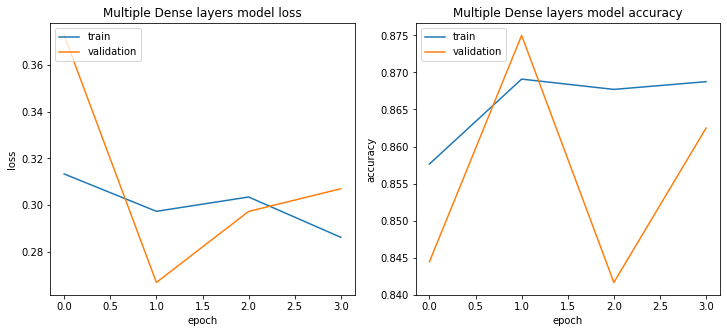

In [36]:
history_es = model2.fit(X_train1, y_train1,
                        epochs=n_epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), 
                        shuffle=True, callbacks=callbacks
                       )
helper.plotTrain(history_es, model_name=model_name2)

In [37]:
score_es = []

score_es = model2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score_es[0], a=score_es[1]))

13/13 [==============================] - 0s 1ms/step - loss: 0.2654 - acc: 0.9000
Multiple Dense layers: Test loss: 0.27 / Test accuracy: 0.90


From the figures of model loss and model accuracy above, the early stopping seems like a bad idea, the train and validation set are not correlated with each other in a consistent way. Accordingly, we will stick on the model without early stopping.

## Change Dropout parameters and activation funtion

### Change Dropout parameters

Then we will compare models with same layers but **different parameters of dropout**.
To simplify out comparsion, we will only use 4 parameters, 0.1, 0.2, 0.5 and 0.7, and check their accuracy. Then we could get a basic idea about how the parameter, which is also known as probability in `Dropout`, affects the model performance.

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.8351 - acc: 0.6660 - val_loss: 0.4952 - val_acc: 0.7528
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.5152 - acc: 0.7661 - val_loss: 0.7169 - val_acc: 0.7708
Epoch 3/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4566 - acc: 0.8059 - val_loss: 0.3829 - val_acc: 0.8292
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4134 - acc: 0.8299 - val_loss: 0.3549 - val_acc: 0.8389
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4001 - acc: 0.8197 - val_loss: 0.3277 - val_acc: 0.8458
Epoch 6/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3668 - acc: 0.8470 - val_loss: 0.3226 - val_acc: 0.8597
Epoch 7/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3819 - acc: 0.8438 - val_loss: 0.4923 - val_acc: 0.7972
Epoch 8/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3561 - acc: 0.85

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF5337C8>,
       dtype=object))

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.6483 - acc: 0.6711 - val_loss: 0.4790 - val_acc: 0.7667
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4797 - acc: 0.7890 - val_loss: 0.5254 - val_acc: 0.7958
Epoch 3/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4281 - acc: 0.8272 - val_loss: 0.3884 - val_acc: 0.8306
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4149 - acc: 0.8369 - val_loss: 0.4014 - val_acc: 0.8417
Epoch 5/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3823 - acc: 0.8349 - val_loss: 0.3807 - val_acc: 0.8236
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3850 - acc: 0.8394 - val_loss: 0.3754 - val_acc: 0.8194
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3498 - acc: 0.8452 - val_loss: 0.3319 - val_acc: 0.8597
Epoch 8/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3462 - acc: 0.85

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF3F7848>,
       dtype=object))

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.6844 - acc: 0.7133 - val_loss: 0.4729 - val_acc: 0.7639
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4790 - acc: 0.7886 - val_loss: 0.4759 - val_acc: 0.7944
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4580 - acc: 0.8147 - val_loss: 0.4126 - val_acc: 0.8208
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4458 - acc: 0.8196 - val_loss: 0.3934 - val_acc: 0.8292
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4072 - acc: 0.8307 - val_loss: 0.4085 - val_acc: 0.8194
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4131 - acc: 0.8114 - val_loss: 0.3457 - val_acc: 0.8458
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3904 - acc: 0.8398 - val_loss: 0.5114 - val_acc: 0.8292
Epoch 8/20
58/58 [==============================] - 0s 8ms/step - loss: 0.3825 - acc: 0.84

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF52F648>,
       dtype=object))

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.7591 - acc: 0.6704 - val_loss: 0.4724 - val_acc: 0.7472
Epoch 2/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4961 - acc: 0.7545 - val_loss: 0.4456 - val_acc: 0.8250
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4370 - acc: 0.8187 - val_loss: 0.3917 - val_acc: 0.8222
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4204 - acc: 0.8285 - val_loss: 0.5203 - val_acc: 0.8181
Epoch 5/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4340 - acc: 0.7980 - val_loss: 0.3568 - val_acc: 0.8403
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4097 - acc: 0.8241 - val_loss: 0.3561 - val_acc: 0.8306
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4115 - acc: 0.8159 - val_loss: 0.3561 - val_acc: 0.8292
Epoch 8/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3957 - acc: 0.83

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224A82F4448>,
       dtype=object))

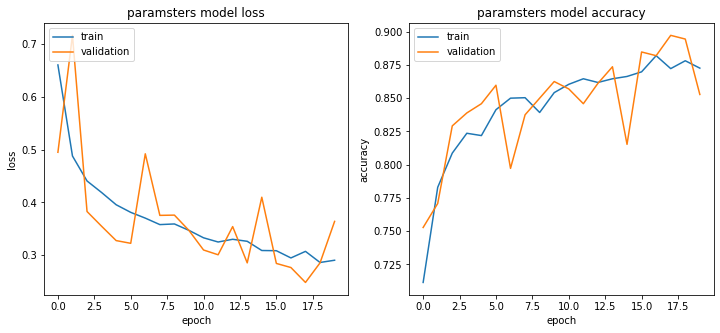

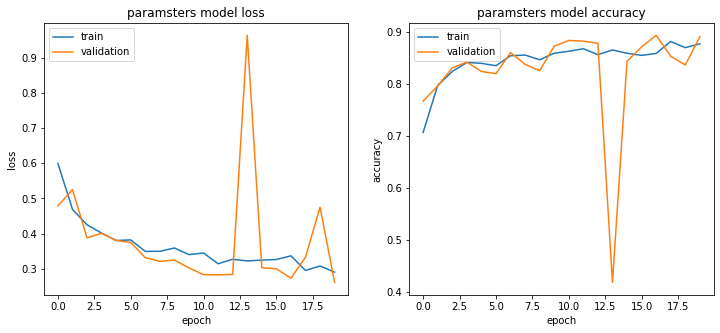

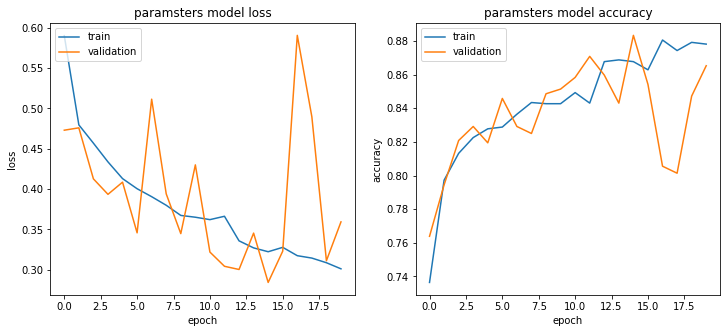

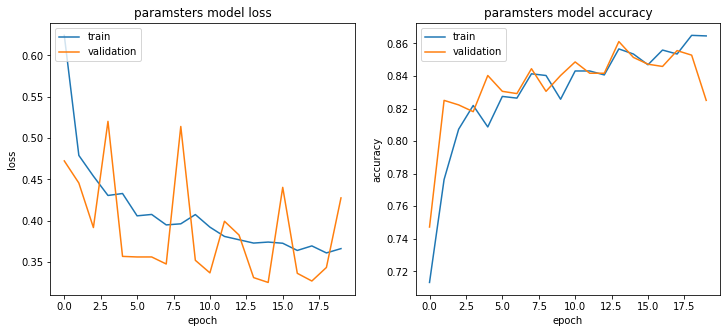

In [38]:
params = [0.1, 0.2, 0.5, 0.7]
score = []
model_name="paramsters"
for i in params:
    model = Sequential([Flatten(input_shape=(80, 80)),
                         layers.Dense(n_hidden_1, activation='relu', name='dense_1'),
                         layers.Dense(n_hidden_2, activation='relu', name='dense_2'),
                         layers.Dense(n_hidden_3, activation='relu', name='dense_3'),
                         Dropout(i),
                         layers.Dense(1, activation='sigmoid', name='dense_head')
                        ])
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
    history = model.fit(X_train1, y_train1,
               epochs=n_epochs, batch_size=batch_size,
               validation_data=(X_val, y_val),
               shuffle=True
              )
    score = model.evaluate(X_test, y_test)
    print("Parameters", i)
    print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score[0], a=score[1]))
    helper.plotTrain(history, model_name=model_name)

From the output above, we can find that test loss is **lowest** when parameter of `Dropout` is equal to 0.2. The test accuracy is **highest** when parameter of `Dropout` is equal to 0.1. Also, the figures show that the overfitting problem is critical when parameter is equal to 0.7. 

Because of the lowest loss, we will still use **0.2** in our model2.

### Change activation function

Then we will check the effect of different activation function. We try activation function **tanh** first.

In [39]:
model3 = Sequential([Flatten(input_shape=(80, 80)),
                     layers.Dense(n_hidden_1, activation='tanh', name='dense_1'),
                     layers.Dense(n_hidden_2, activation='tanh', name='dense_2'),
                     layers.Dense(n_hidden_3, activation='tanh', name='dense_3'),
                     Dropout(0.2),
                     layers.Dense(1, activation='sigmoid', name='dense_head')
                    ])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                192030    
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 101       
Total params: 200,091
Trainable params: 200,091
Non-trainable params: 0
________________________________________________

Epoch 1/20
58/58 [==============================] - 1s 9ms/step - loss: 0.6151 - acc: 0.7041 - val_loss: 0.5649 - val_acc: 0.7472
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.5790 - acc: 0.7352 - val_loss: 0.4855 - val_acc: 0.7472
Epoch 3/20
58/58 [==============================] - 1s 9ms/step - loss: 0.5222 - acc: 0.7367 - val_loss: 0.5574 - val_acc: 0.7097
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4824 - acc: 0.7857 - val_loss: 0.3783 - val_acc: 0.8236
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4421 - acc: 0.7811 - val_loss: 0.4038 - val_acc: 0.8361
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4316 - acc: 0.8203 - val_loss: 0.4655 - val_acc: 0.8181
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4076 - acc: 0.8186 - val_loss: 0.3277 - val_acc: 0.8556
Epoch 8/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3951 - acc: 0.81

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF524948>,
       dtype=object))

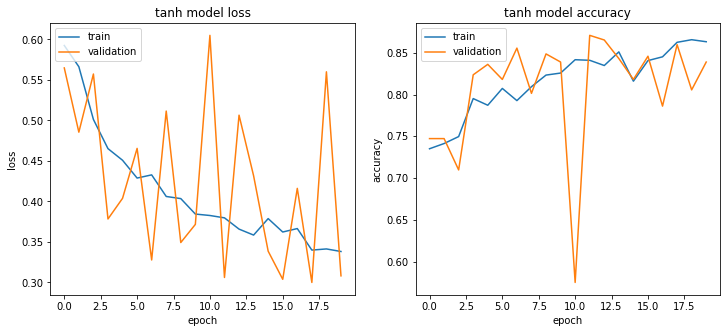

In [40]:
model_name3 = "tanh"

n_epochs = 20
metrics = ["acc"]
batch_size = 50
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history3 = model3.fit(X_train1, y_train1,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_val, y_val),
                      shuffle=True
                     )
helper.plotTrain(history3, model_name=model_name3)

In [41]:
score3 = []

score3 = model3.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score3[0], a=score3[1]))

13/13 [==============================] - 0s 2ms/step - loss: 0.3211 - acc: 0.8000
tanh: Test loss: 0.32 / Test accuracy: 0.80


The test loss and test acccuracy when we use **tanh** as activation model, which are similar to our model using relu. However, the figures shows the overfitting problem. From the perspective of overfitting, **relu is better than tanh.**

Next, we will try **Sigmoid** as our activation function.

In [42]:
model4 = Sequential([Flatten(input_shape=(80, 80)),
                     layers.Dense(n_hidden_1, activation='sigmoid', name='dense_1'),
                     layers.Dense(n_hidden_2, activation='sigmoid', name='dense_2'),
                     layers.Dense(n_hidden_3, activation='sigmoid', name='dense_3'),
                     Dropout(0.2),
                     layers.Dense(1, activation='sigmoid', name='dense_head')
                    ])
model4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                192030    
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 101       
Total params: 200,091
Trainable params: 200,091
Non-trainable params: 0
________________________________________________

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.5745 - acc: 0.7290 - val_loss: 0.6006 - val_acc: 0.7472
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.5127 - acc: 0.7594 - val_loss: 0.5775 - val_acc: 0.7111
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4521 - acc: 0.7986 - val_loss: 0.3773 - val_acc: 0.8292
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.4122 - acc: 0.8246 - val_loss: 0.3414 - val_acc: 0.8375
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3891 - acc: 0.8243 - val_loss: 0.3417 - val_acc: 0.8514
Epoch 6/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3426 - acc: 0.8548 - val_loss: 0.3083 - val_acc: 0.8486
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3702 - acc: 0.8307 - val_loss: 0.4430 - val_acc: 0.7750
Epoch 8/20
58/58 [==============================] - 0s 6ms/step - loss: 0.3599 - acc: 0.84

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AF502B48>,
       dtype=object))

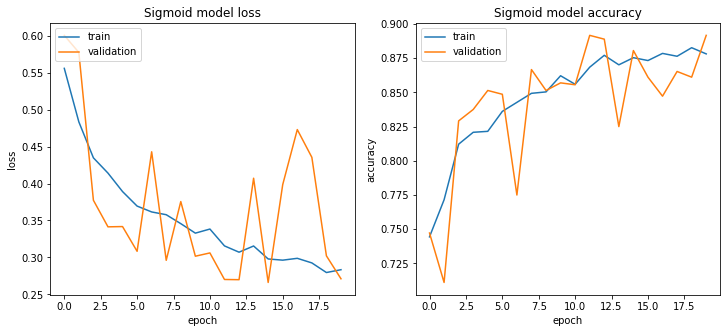

In [43]:
model_name4 = "Sigmoid"

n_epochs = 20
metrics = ["acc"]
batch_size = 50
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history4 = model4.fit(X_train1, y_train1,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_val, y_val),
                      shuffle=True
                     )
helper.plotTrain(history4, model_name=model_name4)

In [44]:
score4 = []

score4 = model4.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score4[0], a=score4[1]))

13/13 [==============================] - 0s 1ms/step - loss: 0.2692 - acc: 0.9000
tanh: Test loss: 0.27 / Test accuracy: 0.90


The **overfitting problem** still exists, but the loss is **lower than the model using tanh**. 

So, basically, we could say that **the model using Sigmoid is better than that using Tanh.**

## Save model2 and history2

**Conclusion: campared with different models, we will use the model2 with relu activation function, units (30, 60, 100), paameter of Dropout 0.2, and early stopping. Thus, the test loss is 0.27, and the test accuracy is 0.9.**

Then, we will save our model2 and history_es.

In [45]:
helper.saveModel(model2, model_name2)
helper.saveHistory(history_es, model_name2)

Directory .\models\Multiple Dense layers already exists, files will be over-written.
Model saved in directory .\models\Multiple Dense layers; create an archive of this directory and submit with your assignment.
Directory .\models\Multiple Dense layers already exists, files will be over-written.
